# Visualize Simulated Boycott Results

In [3]:
from collections import defaultdict, OrderedDict
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt
dataset = 'ml-20m'
if dataset == 'ml-20m':
    NUM_USERS = 138493
    NUM_RATINGS = 20000263

First things first: let's load our master data file (a single, aggregated csv).

In [4]:
df = pd.read_csv('ml-20m_collected/all_results.csv', dtype={'indices': str})
df = df[df.ratingfrac.notna()]
print(df.name.value_counts())

13849 user sample     50
1385 user sample      50
692 user sample       50
137108 user sample    50
83096 user sample     50
124644 user sample    50
96945 user sample     50
110794 user sample    50
27699 user sample     50
55397 user sample     50
41548 user sample     50
138 user sample       50
69 user sample        50
14 user sample        50
6925 user sample      50
69246 user sample     50
Name: name, dtype: int64


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [5]:
df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
# df = df.assign(user_boycott_frac = [x / NUM_USERS for x in df.num_users_boycotting])

# drop columns we're not going to use.
drops = [
    #'tail',
    # 'vanilla',
]
for column in df.columns.values:
    for drop in drops:
        if drop in column:
            df = df.drop(column, axis=1)

# old_df = old_df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in old_df.num_users])

# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [6]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    #'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    #'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
]

organized_experiments = [
    
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'KNNBaseline_item_msd',
    'SVD', 'GlobalMean',
    'MovieMean', 'GuessThree',
    #'KNNBasic_user_msd',
    #'KNNBasic_item_msd',
]
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)
algo_to_metric_vs_knn = defaultdict(dict)
algo_to_metric_vs_user = defaultdict(dict)
algo_to_metric_vs_knnbasicitem = defaultdict(dict)

for algo_name in standard_algo_names:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        'ml-20m', algo_name)
    with open(filename_ratingcv_standards, 'r') as f:
        standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name].get(metric, 0)
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'].get(metric, 0)
        guess_three = standard_results['GuessThree'][metric]
        knn = standard_results.get('KNNBaseline_item_msd', {}).get(metric)
        userval = standard_results.get('KNNBasic_user_msd', {}).get(metric)
        knnbasicitem = standard_results.get('KNNBasic_item_msd', {}).get(metric)
        
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100 if goodval else 0
        if knn:
            print('got knn')
            algo_to_metric_vs_knn[main_algo_name][metric] = (knn - goodval) / goodval * 100 if goodval else 0
        else:
            algo_to_metric_vs_knn[main_algo_name][metric] = algo_to_metric_vs_movie_mean[main_algo_name][metric]
        if userval:
            algo_to_metric_vs_user[main_algo_name][metric] = (userval - goodval) / goodval * 100 if goodval else 0
        else:
            algo_to_metric_vs_user[main_algo_name][metric] = algo_to_metric_vs_movie_mean[main_algo_name][metric]
        if knnbasicitem:
            algo_to_metric_vs_knnbasicitem[main_algo_name][metric] = (knnbasicitem - goodval) / goodval * 100 if goodval else 0
        else:
            algo_to_metric_vs_knnbasicitem[main_algo_name][metric] = algo_to_metric_vs_movie_mean[main_algo_name][metric]
print(algo_to_metric_vs_user)
print('movie', algo_to_metric_vs_movie_mean)
print('standards for SVD', standard_results['SVD'])


got knn
got knn
defaultdict(<class 'dict'>, {'SVD': {'rmse': 19.759535282577247, 'ndcg10': -5.647772312509133}})
movie defaultdict(<class 'dict'>, {'SVD': {'rmse': 19.759535282577247, 'ndcg10': -5.647772312509133}})
standards {'mae': 0.5982146327484761, 'ndcg10': 0.8129494361428661, 'ndcg10_frac': 0.6321670812615489, 'ndcg5': 0.8018415454553228, 'ndcg5_frac': 0.8882993107995836, 'ndcgfull': 0.9157547380976656, 'ndcgfull_frac': 1.0, 'prec10t4': 0.7634889929461244, 'prec10t4_frac': 0.9730377255431292, 'prec5t4': 0.7897671534264847, 'prec5t4_frac': 0.9730377255431292, 'rec10t4': 0.725164049738134, 'rec10t4_frac': 0.9730377255431292, 'rec5t4': 0.5333599422857678, 'rec5t4_frac': 0.9730377255431292, 'rmse': 0.7861107003407806, 'tailndcg10': 0.8025284326387213, 'tailndcg5': 0.8023871407169866, 'tailndcgfull': 0.9381273986072488, 'tailprec10t4': 0.7523732863793005, 'tailprec5t4': 0.7630235092235855, 'tailrec10t4': 0.8950962212516975, 'tailrec5t4': 0.7881534103580077}


In [7]:
algo_to_metric_vs_movie_mean

defaultdict(dict,
            {'SVD': {'ndcg10': -5.647772312509133,
              'rmse': 19.759535282577247}})

In [8]:
samples_df = df[df['type'] == 'sample_users']
if not samples_df.empty:
    print(samples_df[['name', 'num_users', 'num_users_boycotting']].head())
org_df = df[df['type'].isin(organized_experiments)]

                 name  num_users  num_users_boycotting
0  110794 user sample      27699              0.799997
1  110794 user sample      27699              0.799997
2  110794 user sample      27699              0.799997
3  110794 user sample      27699              0.799997
4  110794 user sample      27699              0.799997


In [9]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
#     .replace('US_', '')
#     .replace('state', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]

In [10]:
# for algo_name in algo_names:
#     filt = org_df[org_df.algo_name == algo_name]
#     for metric in metrics:
#         key = 'percent_increase_{}_non-boycott'.format(metric)
#         sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
#         plt.show()
#         slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
#         print(slope, intercept, r_value, p_value)
#         algo_to_metric_to_slope[algo_name][metric] = slope
#         algo_to_metric_to_intercept[algo_name][metric] = intercept
        
#         # calculate the average error for all boycott users in each dataframe
#         algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
#             samples_df[(
#                 (samples_df.algo_name == algo_name) &
#                 (samples_df.userfrac == 1.0) & 
#                 (samples_df.ratingfrac == 1.0)
#             )][key.replace('non-boycott', 'boycott')]
#         )

In [11]:
def select_cols(cols, metrics, groups, percents):
    """
    take a list of cols and filter based on metrics/groups/percents
    
    The returned columns must match all the metrics and groups passed
    if percents is True, return columns with "percent" in the name
    if percents is False return only columns without "percent" in the name
    
    returns a list of cols
    """
    increase_cols = [
        x for x in cols if 'increase' in x and (any(metric == x.split('_')[-2] for metric in metrics))
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [12]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [13]:
palette={'all': 'b', 'non-boycott': 'g'}
TITLE = 'Effect of Boycott Size on Recommender Performance'
YLABEL = 'nDCG@10 personalization factor'

In [37]:
def p_b_curve(
        df, metrics, groups, percents=False,
        reg_plot=False, hue='group', row='metric',
        save=False, normalize=False,
    ):
    
    algo_names = list(set(df.algo_name))
    df = df.copy()
    algo_to_metric_to_group_to = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    if normalize:
        for metric in metrics:
            for algo_name in algo_names:
                movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
                for increase_col in increase_cols:
                    if increase_col.split('_')[-2] == metric:
                        df.loc[df.algo_name == algo_name, increase_col] /= movie_val
    
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)

    grid = sns.lmplot(
        x="num_users_boycotting", y="value", hue=hue, data=longform,
        sharey='row', sharex='col',
        size=4, 
        row=row, col='algo_name',
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
        palette=palette,
        legend_out=True,
    )
    
    if normalize:
        grid.set(ylim=(-1.6, 0.1))

    algo_to_size_to_decreases = defaultdict(lambda: defaultdict(list))
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            for group in groups:
                key = 'increase_{}_{}'.format(metric, group)
                if percents:
                    key = 'percent_' + key
                x = filt.num_users_boycotting
                user_nums = sorted(list(set(filt.num_users_boycotting)))
                nrm_rounded = sorted(list(set(filt.nrm_rounded)))
                y = filt[key]

                num_to_mean = OrderedDict()
                rounded_num_to_mean = OrderedDict()
                for num_users_boycotting in user_nums:
                    filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                    # print('1', len(filt_by_name[key]))
                    num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
                    rounded_num_to_mean[round(num_users_boycotting, 2)] = np.mean(filt_by_name[key])
                nrm_rounded_to_mean = OrderedDict()
                for num in nrm_rounded:
                    filt_by_nrm = filt[filt.nrm_rounded == num]
                    nrm_rounded_to_mean[num] = np.mean(filt_by_nrm[key])

                if group == 'non-boycott':
                    for num in [
                        0.1, 0.3, 0.9
                    ]:
                        
                        val_nb = rounded_num_to_mean.get(num)
                        if val_nb is None:
                            continue
                        val_all = np.mean(filt[filt.num_users_boycotting == num][key.replace('non-boycott', 'all')])
                        ratio_nb = val_nb / algo_to_metric_vs_movie_mean[algo_name][metric]
                        ratio_all = val_all / algo_to_metric_vs_movie_mean[algo_name][metric]
                        print(
                            'Algo:{}  |  Metric:{}  |  #users:{}'.format(
                                algo_name, metric, num, 
                            )
                        )
                        print('NB Val:{}  |  NB Ratio:{}'.format(
                            val_nb,
                            ratio_nb
                        ))
                        print('all Val:{}  |  all Ratio:{}'.format(
                            val_all,
                            ratio_all,
                        ))
                        algo_to_size_to_decreases[algo_name][num].append(ratio_nb)
                meany = np.array(list(num_to_mean.values()))
                meany_ratings = np.array(list(nrm_rounded_to_mean.values()))

                algo_to_metric_to_group_to[algo_name][metric][group]['x'] = user_nums
                algo_to_metric_to_group_to[algo_name][metric][group]['y'] = meany

                #smoothf = interp1d(user_nums, meany, kind='linear', bounds_error=False, fill_value='extrapolate')
                smoothf_ratings = interp1d(nrm_rounded, meany_ratings, kind='quadratic', bounds_error=False, fill_value='extrapolate')

                #algo_to_metric_to_group_to[algo_name][metric][group]['interp'] = smoothf
                algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'] = smoothf_ratings

                algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] = max(user_nums)
                #xnew = np.linspace(min(user_nums), max(user_nums), num=1000)
                algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings'] = np.linspace(
                    min(filt.num_ratings_missing), max(filt.num_ratings_missing), num=1000)

    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        
        zero_line = 0
        movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
        knnbaseline_line = algo_to_metric_vs_knn[algo_name][metric]
        knnbasicitem_line = algo_to_metric_vs_knnbasicitem[algo_name][metric]
        useruser_line = algo_to_metric_vs_user[algo_name][metric]
        movie_val = -1 * algo_to_metric_vs_movie_mean[algo_name][metric]
        movie_line = algo_to_metric_vs_movie_mean[algo_name][metric]
        if normalize:
            knnbaseline_line /= movie_val
            knnbasicitem_line /= movie_val
            useruser_line /= movie_val
            movie_line /= movie_val
        
        ax = grid.axes[i_row, i_col]
#         print(algo_to_metric_to_group_to[algo_name][metric][group]['x'])
#         print(algo_to_metric_to_group_to[algo_name][metric][group]['y'])
    
        linestyle = '-'
        if group == 'all':
            linestyle = '--'
        ax.plot(
            algo_to_metric_to_group_to[algo_name][metric][group]['x'],
            algo_to_metric_to_group_to[algo_name][metric][group]['y'],
            linestyle=linestyle, color=grid._colors[i_hue]
        )
        if not save:
            xnew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['xnew_ratings']
            ynew_ratings = algo_to_metric_to_group_to[algo_name][metric][group]['interp_ratings'](xnew_ratings)
            ax.plot(
                xnew_ratings * algo_to_metric_to_group_to[algo_name][metric][group]['max_user_units'] / NUM_RATINGS,
                ynew_ratings, '-')
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
        if percents:
            ax.axhline(0, color='0.3', linestyle='-')
            ax.axhline(movie_line, color='0.3', linestyle='-')
        
            if algo_name == 'SVD':
                ax.text(0.7, knnbaseline_line+0.05, 'Item KNN + Baselines: 2010')
                ax.axhline(knnbaseline_line, color='y', linestyle=':')
                ax.text(0.7, knnbasicitem_line+0.05, 'Item KNN (1999)')
                ax.axhline(knnbasicitem_line, color='r', linestyle=':')
                ax.axhline(useruser_line, color='c', linestyle=':')
                ax.text(0.7, useruser_line+0.05, 'User KNN (1994)')
    plt.subplots_adjust(hspace=0.2)
    algo_to_size_to_mean_dec = defaultdict(dict)
    for algo_name, size2dec in algo_to_size_to_decreases.items():
        for size, decs in size2dec.items():
            algo_to_size_to_mean_dec[algo_name][size] = np.mean(decs)
    print('=====\nSize to Mean Decrease')
    print(algo_to_size_to_mean_dec)
                   
    grid.set_xlabels('Fraction of users boycotting')
    grid.set_ylabels(YLABEL)
    if save:
        new_labels = ['All\nUsers', 'Not\nBoycotting\nUsers',]
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        grid._legend.set_title('')
        grid.set_titles(TITLE)
        plt.savefig('sample.svg', bbox_inches='tight', dpi=300)
    return algo_to_metric_to_group_to

OrderedDict([(0.0, -0.00011499158286678801), (0.01, -8.20476297927275e-05), (0.05, -0.0002032063099035142), (0.1, -0.0003575970062670919), (0.2, -0.0007465852217268631), (0.3, -0.0012888441545653162), (0.4, -0.0019336762931266094), (0.5, -0.0029195797969430904), (0.6, -0.004343048284246889), (0.7, -0.00661916665521774), (0.8, -0.010135490584376928), (0.9, -0.01794998150811462), (0.99, -0.05046457973413363)])
Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.0003575970062670919  |  NB Ratio:6.331647001332858e-05
all Val:nan  |  all Ratio:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.0012888441545653162  |  NB Ratio:0.00022820398614701272
all Val:nan  |  all Ratio:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.9
NB Val:-0.01794998150811462  |  NB Ratio:0.003178240997491627
all Val:nan  |  all Ratio:nan
OrderedDict([(0.0, -0.0003656644651165153), (0.01, -0.0005837588337927335), (0.05, -0.002734873057777969), (0.1, -0.005378246358143539), (0.2, -0.010661542772088622), (0.3, -0.015

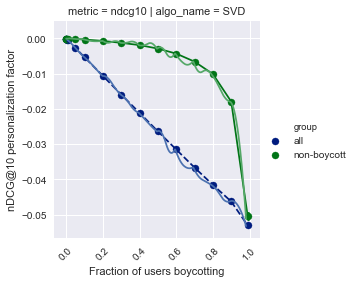

In [40]:
_ = p_b_curve(
    samples_df[samples_df.algo_name == 'SVD'],
    metrics=['ndcg10', ],
    percents=False,
    groups=['non-boycott', 'all', ],
    save=False, normalize=False,
)
plt.show()


In [33]:
algo_to_metric_to_group_to = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all', ],
)

plt.show()

OrderedDict([(0.0, -0.005045609208590065), (0.01, -0.0065028852774432445), (0.05, 0.03098327291589545), (0.1, 0.08510862304957444), (0.2, 0.2081021501420641), (0.3, 0.36706302827418597), (0.4, 0.5678737791568637), (0.5, 0.8263035933121547), (0.6, 1.1956963604228097), (0.7, 1.7407615070399012), (0.8, 2.583247334664693), (0.9, 4.307691585753226), (0.99, 11.299174140930162)])
OrderedDict([(0.0, 0.11177680386574007), (0.01, 0.22686529269353045), (0.05, 1.1617841487842098), (0.1, 2.3229117382718734), (0.2, 4.603116003244441), (0.3, 6.823035959310682), (0.4, 8.999730786321507), (0.5, 11.12075305742502), (0.6, 13.197680142062692), (0.7, 15.235220785209172), (0.8, 17.21544889425139), (0.9, 19.292800912175124), (0.99, 23.119712270888186)])
OrderedDict([(0.0, -0.01414507744562091), (0.01, -0.010092614729368956), (0.05, -0.024995872071677222), (0.1, -0.043987773758898924), (0.2, -0.09183655422532246), (0.3, -0.1585395258709511), (0.4, -0.23785204730078685), (0.5, -0.35912440463391065), (0.6, -0.5

ValueError: x and y must have same first dimension, but have shapes (16,) and (13,)

In [ ]:
movie_val = -1 * algo_to_metric_vs_movie_mean['SVD']['ndcg10']
print(algo_to_metric_vs_knnbasicitem['SVD']['ndcg10']/movie_val)
for group in ['all', 'non-boycott']:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, NUM_RATINGS, NUM_RATINGS//10000):
        y = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](x)
        #print(x, y)
        
        if not found_item:
            if y <= algo_to_metric_vs_knn['SVD']['ndcg10']/movie_val:
                print(group + ' found item:')
                print(x/NUM_RATINGS)
                found_item = True
        if not found_user:
            if y <= algo_to_metric_vs_user['SVD']['ndcg10']/movie_val:
                print(group + ' found user')
                print(x/NUM_RATINGS)
                found_user = True
        if not found_itembasic:
            if y <= algo_to_metric_vs_knnbasicitem['SVD']['ndcg10']/movie_val:
                print(group + ' found knnbasicitem')
                print(x/NUM_RATINGS)
                found_itembasic = True

In [ ]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [ ]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [ ]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [ ]:
normed_org_df = org_df.copy()
for metric in metrics:
    for algo_name in algo_names:
        movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
        for group in ['non-boycott', 'like-boycott']:
            col = 'percent_increase_{}_{}'.format(metric, group)
            if normalize:
                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = 'percent_increase_{}_expected'.format(metric)
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

In [ ]:
NORMALIZE = True

In [22]:
def plot2(
        df, metrics, groups,
        percents=False, kind='bar', size=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    #df = input_df.copy()

    print('len of df', len(df.index))
    for name in list(set(df.name)):
        tmp = df[df.name == name].num_ratings_missing.mean()
        print(name)
        print(tmp)
        print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
#     for metric in metrics:
#         for col in increase_cols:
#             if metric in col and 'expected' in col:
#                 expec = col
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(list)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]
        val = algo_to_metric_vs_movie_mean[algo_name][metric]
        
        
        if NORMALIZE:
            movie_val = abs(algo_to_metric_vs_movie_mean[algo_name][metric])
            val /= movie_val
        
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
            #grid.axes[i_row, i_col].axhline(val, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
                elif 'like-boycott' in col:
                    lb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                lb_arr = np.array(masked[masked.increase_type == lb].value)
                
                expec_mean = np.mean(expec_arr)
                nb_mean = np.mean(nb_arr)
                lb_mean = np.nanmean(lb_arr)
                
                ratio = nb_mean / expec_mean
                diff = nb_mean - expec_mean
                lb_diff = lb_mean - nb_mean
                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue
                #lb_vs_nb = stats.ttest_ind(lb_arr, nb_arr, equal_var=False).pvalue
                if True:# < 0.05:
                    pass
#                     if abs(ratio) >= 1.5 and diff < 0:
#                         print('Very effective...')
#                     elif abs(ratio) <= 0.67 and diff > 0:
#                         print('Very ineffective...')
#                     else:
#                         continue
                else:
                    continue
                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                name_to_ratios[name].append(ratio)
                diffs['nb'].append(lb_diff)
                diffs['lb'].append(lb_diff)
                name_to_counts[name]['total_sig'] += 1
                if diff >= 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                print(lb)
                print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']
#         print(name)
#         print('{} sig, {} less, and {} more out of {} total'.format(
#             counts['total_sig'], counts['total_less'],
#             counts['total_more'], counts['total'])
#         )
#         print('Mean:')
    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Users Similar\n to Boycotting\n Users', 'Not Boycotting\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(YLABEL)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), diffs


In [23]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [24]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']

# removing these from contention
# genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']
# state_boycotts = org_df[org_df['type'] == 'state']

In [25]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c'}

def plot_all_three_scenarios(df, size=6):
    if False:
        all_df = all_users_all_ratings(df)
        if not all_df.empty:
            grid, (total, total_sig, total_less, total_more, total_lbless) = plot2(
                all_users_all_ratings(df),
                metrics=metrics,
                percents=True,
                groups=['all', 'non-boycott', 'expected'],
                size=size,
                palette=palette
            )
            grid.fig.suptitle('All Users, All Ratings')
            print('total1', total)
    else:
        total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), ntd = plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            size=size,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
        
#     half_ratings_df = half_ratings(df)
#     if not half_ratings_df.empty:
#         plot2(
#             half_ratings_df,
#             metrics=metrics,
#             percents=True,
#             groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
#             size=size,
#         ).fig.suptitle('Half Ratings')
#     plt.show()
    
    return (total, total_sig, total_less, total_more, total_lbless), ntd

In [26]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
lbdiffs = []
diffs = []

# Make plots for paper here.

len of df 80
power users
190338.05
-0.11302769985665324
male users
375947.55
-0.29115748811954834
female users
124734.0
-0.059993512414410935
fans of film-noir
63147.6
-0.016559214068952215


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 SVD power users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.6748878353682681, pval: 1.2790282191657302e-07
percent_increase_ndcg10_like-boycott
lb info -0.28887224849680154 -0.4781868632007346 -0.18931461470393307
ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.1214421607655032, pval: 0.01065906164058103
percent_increase_ndcg10_like-boycott
lb info -0.09246718700146117 -0.4190639421654413 -0.3265967551639801
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6160046559005126, pval: 0.013040910971429799
percent_increase_ndcg10_like-boycott
lb info -0.018481621472703734 -0.05544490753163141 -0.03696328605892767
ndcg10 SVD fans of film-noir, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 3.257517102735211, pval: 2.487621635325052e-05
percent_increase_ndcg10_like-boycott
lb info -0.18599859814631137 -0.2399615479

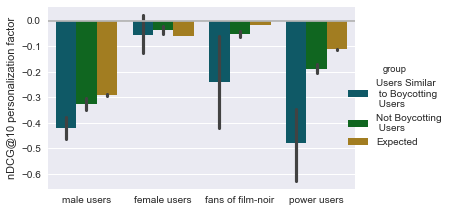

In [27]:

df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)
#df4 = all_users_all_ratings(occupation_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), ntd = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('film-noir')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=['ndcg10'],
    percents=True,
    groups=['non-boycott', 'like-boycott', 'expected'],
    size=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=True,
    palette=palette,
    aspect=1.5
)

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df2[(df2.name.str.contains('Film-Noir')) & (df2.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h2.svg', save=True,
#     palette=palette
# )

# grid, (total, total_sig, total_less, total_more) = plot2(
#     df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')],
#     metrics=['ndcg10'],
#     percents=True,
#     groups=['non-boycott', 'expected', 'like-boycott',],
#     size=2.5,
#     kind='bar',
#     flip=True,
#     filename='h3.svg', save=True,
#     palette=palette
# )




plt.show()


## Let's do gender first...

In [28]:
124734.0*2 / NUM_RATINGS

0.24941587208273472

len of df 40
male users
375947.55
-0.29115748811954834
female users
124734.0
-0.059993512414410935


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 SVD male users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.1214421607655032, pval: 0.01065906164058103
percent_increase_ndcg10_like-boycott
lb info -0.09246718700146117 -0.4190639421654413 -0.3265967551639801
ndcg10 SVD female users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.6160046559005126, pval: 0.013040910971429799
percent_increase_ndcg10_like-boycott
lb info -0.018481621472703734 -0.05544490753163141 -0.03696328605892767
Totals:
2 lbless, 2 sig, 1 less, and 1 more out of 2 total
total2 2 2
[-0.09246718700146117, -0.018481621472703734]


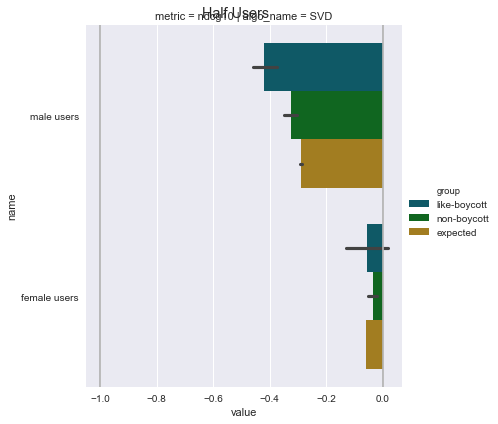

In [29]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']
print(diffs)
plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df 40
bottom 10% contributors
7213.2
0.016894784522087643
power users
190338.05
-0.11302769985665324


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 SVD bottom 10% contributors, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 4.106074007079791, pval: 1.4556953064024207e-07
percent_increase_ndcg10_like-boycott
lb info -1.8078085916799327 -1.7384373593330684 0.06937123234686426
ndcg10 SVD power users, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.6748878353682681, pval: 1.2790282191657302e-07
percent_increase_ndcg10_like-boycott
lb info -0.28887224849680154 -0.4781868632007346 -0.18931461470393307
Totals:
2 lbless, 2 sig, 1 less, and 1 more out of 2 total
total2 2 2


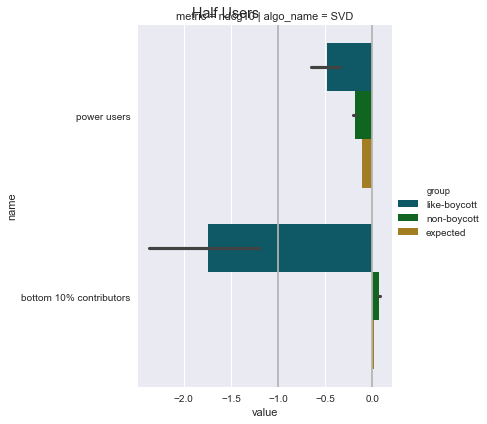

In [30]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']


plt.show()

len of df 140
50-55
36205.35
0.0002670488847310434
45-49
41306.85
-0.002817392761531658
35-44
99619.1
-0.0414457702732811
56+
19843.45
0.009839458617814266
18-24
91701.25
-0.035836815463781986
under 18
13785.2
0.013259936018357366
25-34
198664.2
-0.12004309077818827


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 SVD 50-55, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 8.840861645242331, pval: 0.7651921426667849
percent_increase_ndcg10_like-boycott
lb info 0.03725577605712509 0.03958658910548184 0.002330813048356751
ndcg10 SVD 45-49, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -3.6193987771250065, pval: 0.08384491015167295
percent_increase_ndcg10_like-boycott
lb info 0.0671099469261467 0.07731955933592581 0.010209612409779103
ndcg10 SVD 35-44, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.8315249171582008, pval: 0.429562017456398
percent_increase_ndcg10_like-boycott
lb info -0.01783358636841014 -0.052305911199808576 -0.034472324831398435
ndcg10 SVD 56+, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 3.387121467921116, pval: 0.00011914575878212035
percent_increase_ndcg10_like-boycott
lb info 0.005600567202154502 0.038924118926873565 0.03332355172471906
ndcg10 SVD 

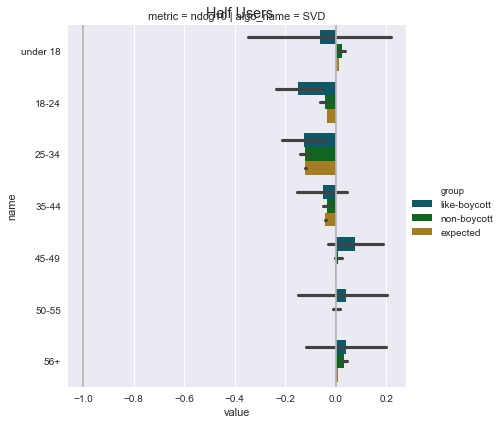

In [31]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']
print(diffs)


plt.show()


len of df 420
clerical/admin
15329.5
0.012394383523412406
homemaker
5604.3
0.017772634234005998
technician/engineer
36898.3
-0.00014913314136535873
artist
24724.9
0.007034704766803539
lawyer
9662.6
0.015549275894638611
writer
30434.9
0.003698739956518131
customer service
10758.65
0.014943648275797502
tradesman/craftsman
5999.6
0.01755738769204081
academic/educator
42088.6
-0.003294244197564968
self-employed
23266.25
0.007877359709629186
scientist
11196.6
0.014701044316170423
retired
6891.25
0.01707082504122328
college/grad student
66676.0
-0.01886084657109758
doctor/health care
18143.7
0.010805890020267672
k-12 student
11371.7
0.01460394916313386
other
65295.8
-0.017957816077948035
executive/managerial
52689.75
-0.009870765705463143
farmer
1136.3
0.02018571019258739
unemployed
7810.05

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])



0.016567930109109882
sales/marketing
24670.95
0.007065940522179754
programmer
28882.55
0.004611557896126304
ndcg10 SVD clerical/admin, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.6748908952801682, pval: 0.312134295326039
percent_increase_ndcg10_like-boycott
lb info 0.18830218055011422 0.2090593376104927 0.02075715706037847
ndcg10 SVD homemaker, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 2.384947193782035, pval: 0.02889758785135035
percent_increase_ndcg10_like-boycott
lb info 0.06710552661632299 0.10949153081197541 0.042386004195652416
ndcg10 SVD technician/engineer, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: -93.35719785826734, pval: 0.17357366050434014
percent_increase_ndcg10_like-boycott
lb info 0.03040320224107417 0.04469946131479534 0.01429625907372117
ndcg10 SVD artist, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 1.5487971770285718, pval: 0.66047

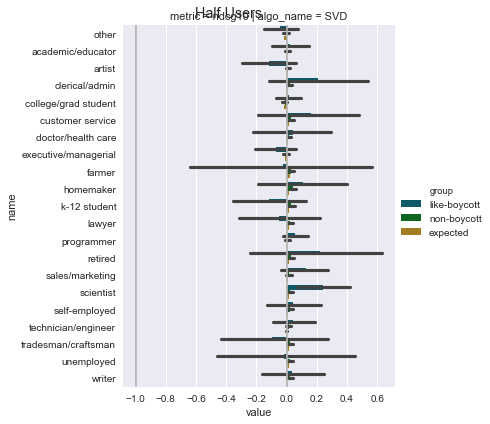

In [32]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs += ntd['lb']
diffs += ntd['nb']


plt.show()

len of df 360
fans of war
134025.7
-0.06714709979604282
fans of action
62644.1
-0.016232624025317752
fans of romance
75700.25
-0.0248508069103006
fans of comedy
75372.6
-0.024630726729872515
fans of animation
61326.65
-0.01538026137332319
fans of thriller
82779.25
-0.029653532217800316
fans of adventure
51318.9
-0.00900880791876564
fans of documentary
21881.2
0.008673904714887569
fans of film-noir
63147.6
-0.016559214068952215
fans of crime
88663.9
-0.03371551845268055
fans of western
26131.95
0.006218182036130163
fans of horror

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])



24414.75
0.007214201716090296
fans of drama
142555.85
-0.07385300371253792
fans of mystery
53860.55
-0.010609650353264753
fans of fantasy
22876.25
0.00810200335563384
fans of musical
60833.5
-0.015062017828876392
fans of sci-fi
50312.6
-0.008378251802294298
fans of children's
42879.55
-0.003777841752838483
ndcg10 SVD fans of war, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.9930371901611053, pval: 0.9591852419934459
percent_increase_ndcg10_like-boycott
lb info -0.02023056129545972 -0.08691446441453499 -0.06668390311907527
ndcg10 SVD fans of action, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.39852116294859163, pval: 0.22924720603593013
percent_increase_ndcg10_like-boycott
lb info -0.0605432597126603 -0.06701414308532642 -0.006470883372666124
ndcg10 SVD fans of romance, percent_increase_ndcg10_expected, percent_increase_ndcg10_non-boycott
Ratio: 0.781235153361706, pval: 0.500003630725431
percent_increase_ndcg10_like-b

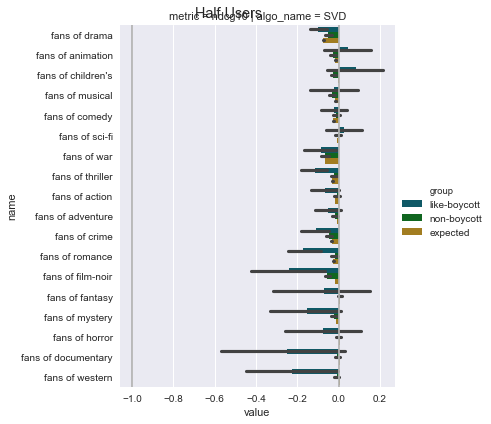

In [33]:
(total, total_sig, total_less, total_more, total_lbless), ntd = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
lbdiffs.append(ntd['lb'])
diffs.append(ntd['nb'])

plt.show()

In [34]:
63147.6 *2 / NUM_RATINGS

0.12626880981874788

In [35]:
running_totals

{'total': 50,
 'total_lbless': 30,
 'total_less': 35,
 'total_more': 15,
 'total_sig': 50}

In [36]:
print(np.mean(lbdiffs), np.mean(diffs))

ValueError: setting an array element with a sequence.